## Earth observation images time series interpolation

In [1]:
# Start client parallel processing

from dask.distributed import Client

client = Client(n_workers=8)
client

<Client: scheduler='tcp://127.0.0.1:48066' processes=8 cores=24>

In [13]:
client.close()

In [1]:
#stack_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/'
#files = list(map(lambda x: stack_dir+x, list(filter(re.compile('S2').search, os.listdir(stack_dir)))))
#data_alt_chunk = xr.open_mfdataset(files, chunks={'x':1000,'y':1000}, parallel=True)

In [2]:
import sys
sys.path.append('../b_Temporal_Stack')

import regionstack
import eotempstack
import xr_eotemp

saldana = regionstack.regionStack('Saldana2', attrs=['S2','LC08'])

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana2/pre/
Reading 3 S2 stack files
Reading 9 hLC08 stack files
Harmonized Landsat-8 dataset was read


In [3]:
import os
import numpy as np
import xarray as xr

In [4]:
saldana.LC08['mask'] = saldana.LC08.mask.astype(bool)

In [5]:
sentinel = saldana.S2.transpose('y','x','time')
landsat = saldana.LC08.transpose('y','x','time')

In [6]:
aligned = xr.align(sentinel, landsat,exclude={'time'})

In [7]:
#optical = xr.concat(aligned, dim='time')

In [8]:
# For calculating ndvi, make sure to make not valid pixels NAs?

#optical['NDVI'] = (optical.nir - optical.red) / (optical.nir + optical.red)
#optical['LSWI'] = (optical.nir - optical.swir1) / (optical.nir + optical.swir1)

In [9]:
aligned[0].to_netcdf(saldana.data_directory+'vars/'+'sentinel.nc')
aligned[1].to_netcdf(saldana.data_directory+'vars/'+'landsat.nc')

### Read back the variable files

In [3]:
import os
import xarray as xr

dirc=os.environ['WIN_SVR_DATA']+'Saldana2/vars/'

opticalrr = xr.open_mfdataset([dirc+x for x in ['sentinel.nc','landsat.nc']],chunks={'y':1000,'x':750,'time':22})

In [4]:
opticalrr = opticalrr.isel(x=slice(0,100),y=slice(0,100))

In [5]:
opticalrr['mask'] = opticalrr.mask.astype(bool)
nir = opticalrr.nir.where(opticalrr.mask)
#red = opticalrr.red.where(opticalrr.mask)
swir1 = opticalrr.red.where(opticalrr.mask)
#opticalrr['NDVI'] = (nir - red) / (nir + red)
opticalrr['LSWI'] = (nir - swir1) / (nir + swir1)

In [6]:
opticalrr['NDVI'].to_netcdf(dirc+'ndvi.nc')
opticalrr['LSWI'].to_netcdf(dirc+'lswi.nc')

In [5]:
opticalrr# = opticalrr.chunk({'time':-1,'y':50,'x':50})

<xarray.Dataset>
Dimensions:  (time: 22, x: 100, y: 100)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...
    mask     (y, x, time) int8 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>
Data variables:
    blue     (y, x, time) uint16 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>
    green    (y, x, time) uint16 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>
    red      (y, x, time) uint16 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>
    nir      (y, x, time) uint16 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>
    swir1    (y, x, time) uint16 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>
    swir2    (y, x, time) uint16 dask.array<shape=(100, 100, 22), chunksize=(100, 100, 7)>

In [17]:
from interpolatets import calculate_time_periods
import numpy as np

doi, times = calculate_time_periods(_dataset, date_of_analysis=np.datetime64('2015-12-22'))
print('For {}, the following {} times will be interpolated: {}'.format(doi, times.shape[0], times))

For 2015-12-22, the following 12 times will be interpolated: ['2016-01-07' '2015-12-22' '2015-12-06' '2015-11-20' '2015-11-04'
 '2015-10-19' '2015-10-03' '2015-09-17' '2015-09-01' '2015-08-16'
 '2015-07-31' '2015-07-15']


### Interpolate variables

In [1]:
from dask.distributed import Client

client = Client(n_workers=8)
client

<Client: scheduler='tcp://127.0.0.1:39636' processes=8 cores=24>

In [2]:
import sys
sys.path.append('../b_Temporal_Stack')
import interpolatets as intr
import os
import numpy as np
import xarray as xr

client.upload_file('../b_Temporal_Stack/interpolatets.py')

dirc=os.environ['WIN_SVR_DATA']+'Saldana2/vars/'
#_location = os.environ['WIN_SVR_DATA']+'Saldana2/features2/'
_dataset = xr.open_dataset(dirc+'lswi.nc', chunks={'y':250,'x':250,'time':22})

In [3]:
testds = _dataset.isel(x=slice(0,100),y=slice(0,100)).chunk({'time':-1,'y':50,'x':50})
testds

<xarray.Dataset>
Dimensions:  (time: 22, x: 100, y: 100)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...
    mask     (y, x, time) bool dask.array<shape=(100, 100, 22), chunksize=(50, 50, 22)>
Data variables:
    LSWI     (y, x, time) float64 dask.array<shape=(100, 100, 22), chunksize=(50, 50, 22)>

In [6]:
a = testds.LSWI.where(testds.mask).sortby('time').interpolate_na(dim='time', method='cubic')

In [25]:
doi, times = intr.calculate_time_periods(a, date_of_analysis=np.datetime64('2015-12-22'), time_delta=16)

In [31]:
times.tolist()

[datetime.date(2016, 1, 7),
 datetime.date(2015, 12, 22),
 datetime.date(2015, 12, 6),
 datetime.date(2015, 11, 20),
 datetime.date(2015, 11, 4),
 datetime.date(2015, 10, 19),
 datetime.date(2015, 10, 3),
 datetime.date(2015, 9, 17),
 datetime.date(2015, 9, 1),
 datetime.date(2015, 8, 16),
 datetime.date(2015, 7, 31),
 datetime.date(2015, 7, 15)]

In [7]:
a = a.isel(time=slice(2,-1))

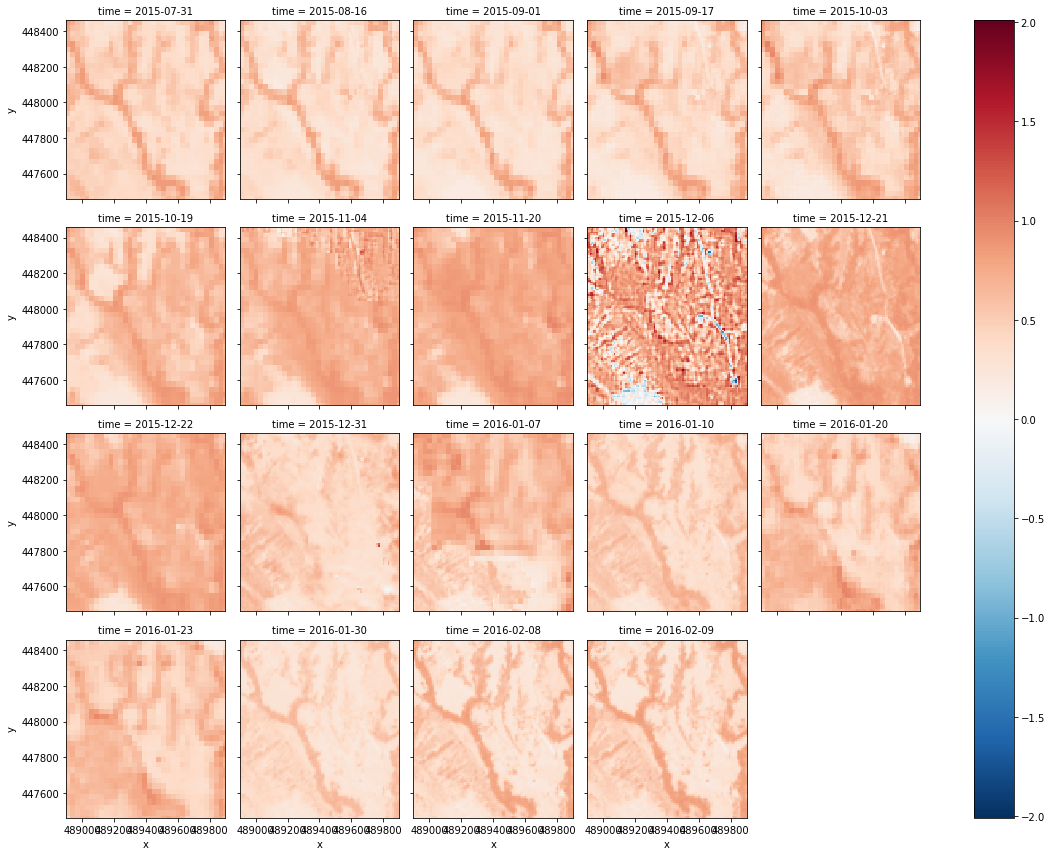

In [34]:
a.plot(col='time', col_wrap=5)

In [8]:
_location2 = os.environ['WIN_SVR_DATA']+'Saldana2/features2/'

In [9]:
ds = xr.Dataset({'LSWI':a.drop('mask')})
ds

<xarray.Dataset>
Dimensions:  (time: 19, x: 100, y: 100)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-07-31 2015-08-16 2015-09-01 ...
Data variables:
    LSWI     (y, x, time) float64 dask.array<shape=(100, 100, 19), chunksize=(50, 50, 19)>

In [5]:
testds

<xarray.Dataset>
Dimensions:  (time: 22, x: 100, y: 100)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...
    mask     (y, x, time) bool dask.array<shape=(100, 100, 22), chunksize=(50, 50, 22)>
Data variables:
    LSWI     (y, x, time) float64 dask.array<shape=(100, 100, 22), chunksize=(50, 50, 22)>

In [9]:

intr.interpolate_dataset(testds, _location2,
                    bands=['LSWI'],
                    date_of_analysis=np.datetime64('2015-12-22'),
                        der=True)


Date of analysis is 2015-12-22, interpolating:
['2016-01-07' '2015-12-22' '2015-12-06' '2015-11-20' '2015-11-04'
 '2015-10-19' '2015-10-03' '2015-09-17' '2015-09-01' '2015-08-16'
 '2015-07-31' '2015-07-15']
Writing LSWI band to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana2/features2/LSWI_der.nc
Done!


In [10]:
import xarray as xr

lswi_file = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana2/features2/LSWI_der.nc'

lswi = xr.open_dataset(lswi_file)#, chunks={'y':50,'x':50,'time':22})

In [11]:
lswi = lswi.load()

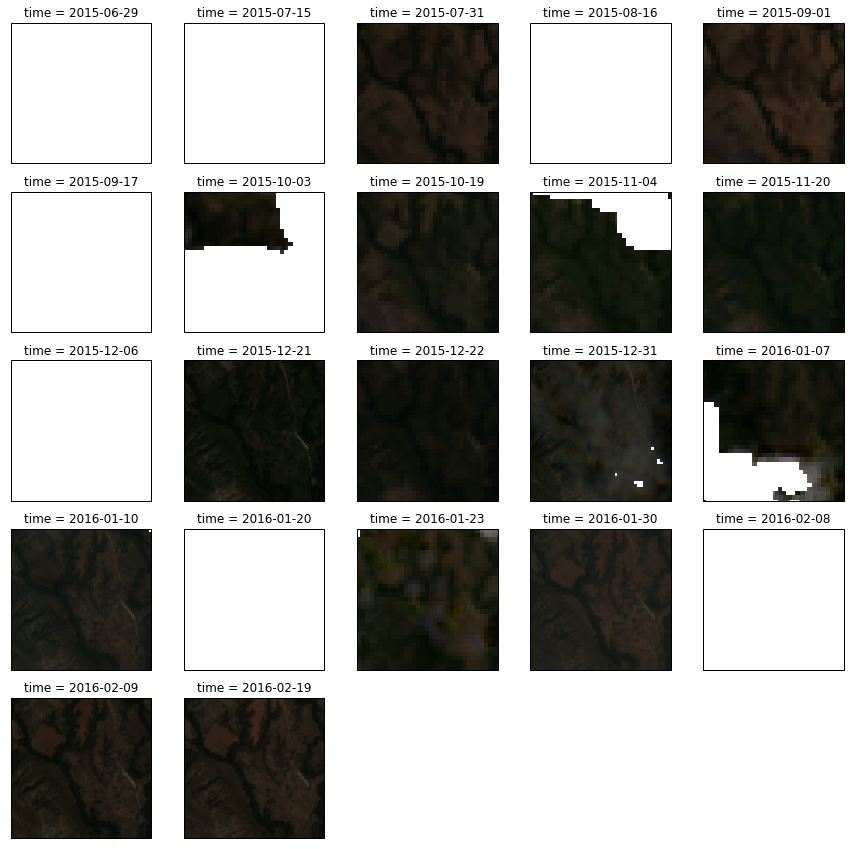

In [7]:
import sys
sys.path.append('../b_Temporal_Stack')

import xr_eotemp

opticalrr.where(opticalrr.mask).eotemp.plot_RGB()

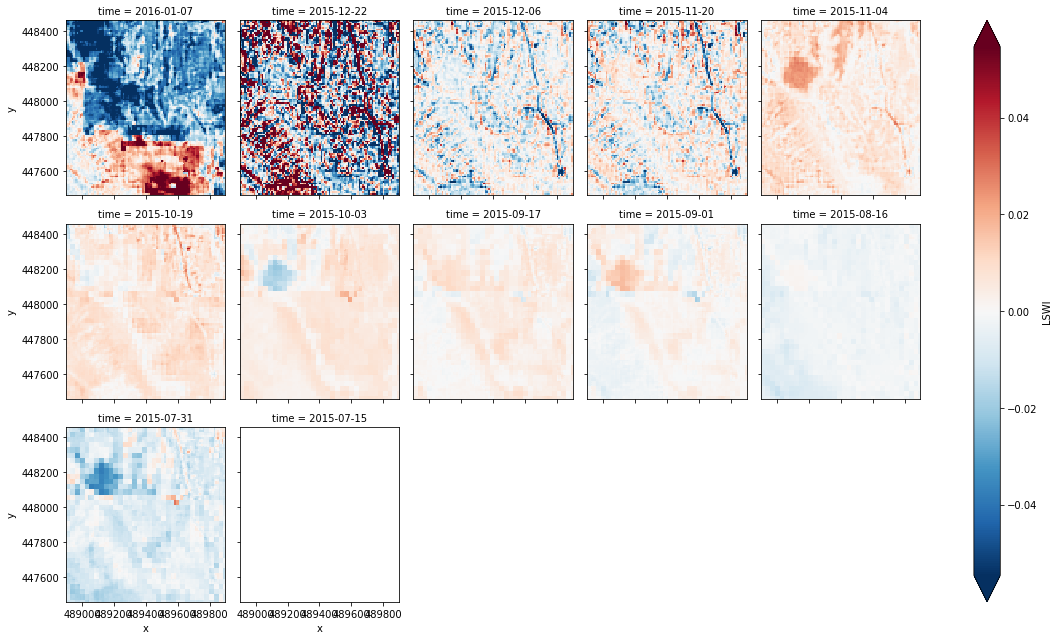

In [14]:
lswi.LSWI.plot(col='time', col_wrap=5, robust=True)

In [28]:
lswi.LSWI.to_dataset(dim='time')

<xarray.Dataset>
Dimensions:    (x: 100, y: 100)
Coordinates:
  * x          (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y          (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
Data variables:
    LSWI_16    (y, x) float32 -0.041616037 -0.04555955 -0.036278047 ...
    LSWI_0     (y, x) float32 -0.017595703 -0.011697678 0.0005997909 ...
    LSWI_-16   (y, x) float32 -0.0017661504 -0.003557957 -0.0017263847 ...
    LSWI_-32   (y, x) float32 0.021479184 0.01985166 -0.0009942581 ...
    LSWI_-48   (y, x) float32 -0.00036971236 6.720694e-05 0.001665058 ...
    LSWI_-64   (y, x) float32 -0.015262779 -0.015382932 -0.0009284185 ...
    LSWI_-80   (y, x) float32 0.004744798 0.00478849 -0.00046769678 ...
    LSWI_-96   (y, x) float32 0.002907535 0.0029020736 0.003559097 ...
    LSWI_-112  (y, x) float32 0.0007505984 0.0007287524 0.0033568458 ...
    LSWI_-128  (y, x) float32 -0.0017260121 -0.0017314736 -0.0010744503 ...
    LSWI_-144  (y, x) float32

In [27]:
lswi['time'] = list(map(lambda x: 'LSWI_'+str(x), int_orig_times))

In [26]:
list(map(lambda x: 'LSWI_'+str(x), int_orig_times))

['LSWI_16',
 'LSWI_0',
 'LSWI_-16',
 'LSWI_-32',
 'LSWI_-48',
 'LSWI_-64',
 'LSWI_-80',
 'LSWI_-96',
 'LSWI_-112',
 'LSWI_-128',
 'LSWI_-144',
 'LSWI_-160']

In [22]:
import pandas as pd

time_base = np.datetime64('2015-12-22')
int_orig_times = (pd.to_datetime(lswi.time.values) - time_base).days.values
int_orig_times

array([  16,    0,  -16,  -32,  -48,  -64,  -80,  -96, -112, -128, -144,
       -160])

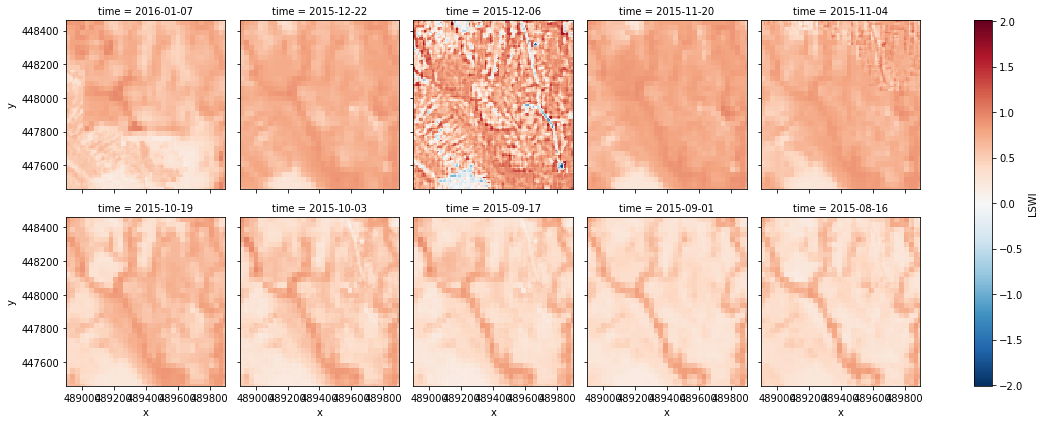

In [13]:
lswi.LSWI.plot(col='time', col_wrap=5)

In [4]:
import os
import xarray as xr

dirc=os.environ['WIN_SVR_DATA']+'Saldana2/vars/'

files = [dirc+x for x in os.listdir(dirc) if x not in ['optical.nc','landsat.nc','sentinel.nc']]

lswi_file = files[2]

In [7]:
opticalrr

<xarray.Dataset>
Dimensions:  (time: 22, x: 2974, y: 3626)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...
    mask     (y, x, time) bool dask.array<shape=(3626, 2974, 22), chunksize=(1000, 750, 22)>
Data variables:
    LSWI     (y, x, time) float64 dask.array<shape=(3626, 2974, 22), chunksize=(1000, 750, 22)>

In [9]:
_location = os.environ['WIN_SVR_DATA']+'Saldana2/features/'


import interpolatets as intr

da=intr.interpolate_dataset(testds, _location,
                    bands=['LSWI'],
                    date_of_analysis=np.datetime64('2015-12-22'))

ModuleNotFoundError: No module named 'interpolatets'

In [4]:
testds = opticalrr.isel(x=slice(0,100),y=slice(0,100),time=slice(3,-1)).chunk({'time':-1,'y':50,'x':50})

In [5]:
_location = os.environ['WIN_SVR_DATA']+'Saldana2/features2/'
da=intr.interpolate_dataset(testds, _location,
                    bands=['red'],
                    date_of_analysis=np.datetime64('2015-12-22'))

Date of analysis is 2015-12-22, interpolating:
['2016-01-07' '2015-12-22' '2015-12-06' '2015-11-20' '2015-11-04'
 '2015-10-19' '2015-10-03' '2015-09-17' '2015-09-01']
Writing red band to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana2/features2/


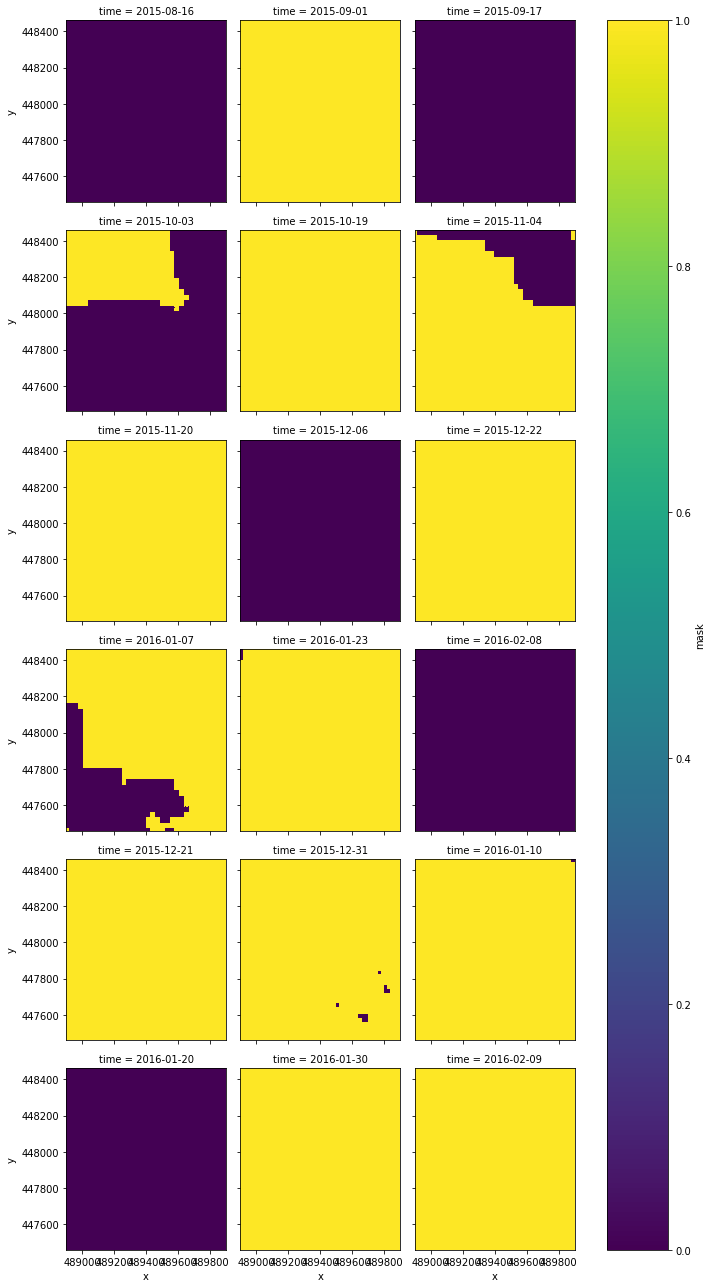

In [28]:
testds.mask.plot(col='time', col_wrap=3)

In [8]:
da#.plot(col='itime', col_wrap=3)

<xarray.DataArray 'red' (y: 100, x: 100, itime: 9)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * itime    (itime) datetime64[ns] 2016-01-07 2015-12-22 2015-12-06 ...

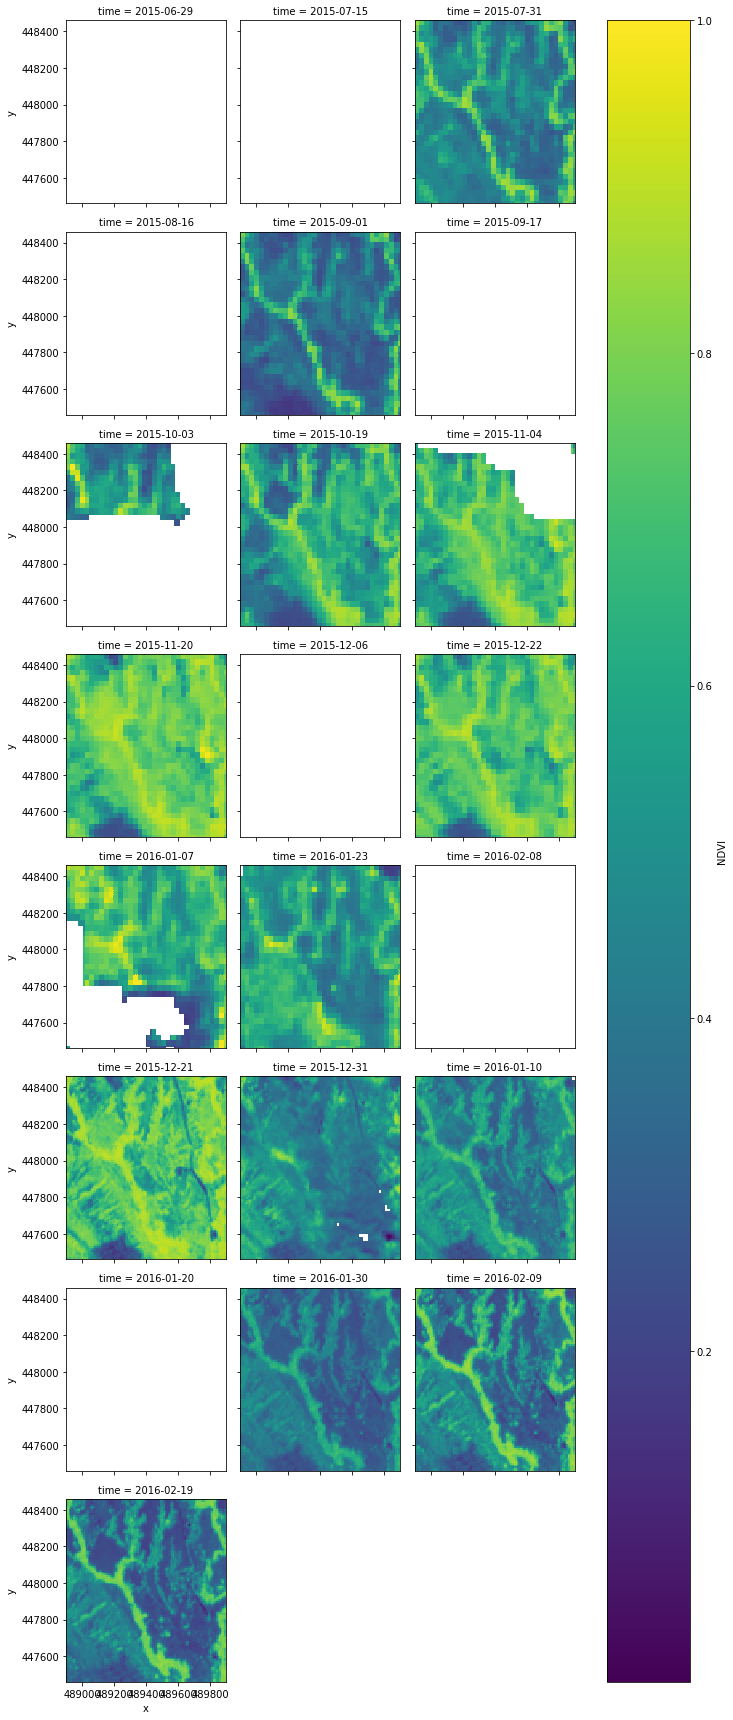

In [20]:
testds.NDVI.plot(col='time', col_wrap=3)

In [14]:
frozenset(['time']) <= frozenset(['time'])

True

In [8]:
test = xr.open_dataset(os.environ['WIN_SVR_DATA']+'Saldana2/features/NDVI.nc')

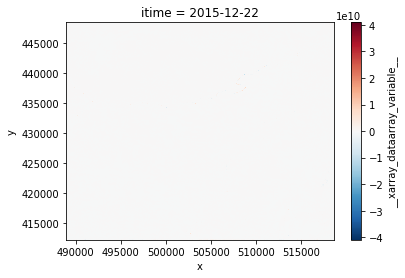

In [13]:
test.__xarray_dataarray_variable__.isel(itime=1).plot()

In [20]:
_dataset.time

<xarray.DataArray 'time' (time: 22)>
array(['2015-06-29T00:00:00.000000000', '2015-07-15T00:00:00.000000000',
       '2015-07-31T00:00:00.000000000', '2015-08-16T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-09-17T00:00:00.000000000',
       '2015-10-03T00:00:00.000000000', '2015-10-19T00:00:00.000000000',
       '2015-11-04T00:00:00.000000000', '2015-11-20T00:00:00.000000000',
       '2015-12-06T00:00:00.000000000', '2015-12-22T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-23T00:00:00.000000000',
       '2016-02-08T00:00:00.000000000', '2015-12-21T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-20T00:00:00.000000000', '2016-01-30T00:00:00.000000000',
       '2016-02-09T00:00:00.000000000', '2016-02-19T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-06-29 2015-07-15 2015-07-31 ...

In [26]:
filled = _dataset.sortby('time').chunk({'time':-1}).interpolate_na(dim='time')

In [27]:
filled

<xarray.Dataset>
Dimensions:  (time: 22, x: 2974, y: 3626)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-06-29 2015-07-15 2015-07-31 ...
    mask     (y, x, time) bool dask.array<shape=(3626, 2974, 22), chunksize=(250, 250, 22)>
Data variables:
    NDVI     (y, x, time) float64 dask.array<shape=(3626, 2974, 22), chunksize=(250, 250, 22)>

In [29]:
xrint = filled.interp(time=times, method='cubic')

In [31]:
xrint.to_netcdf(_location+'xr_ndvi.nc')

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 34, 26, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 34, 26, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 34, 26, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 34, 26, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 33, 16, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 33, 16, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "(

distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 8, 25, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 4, 16, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 4, 16, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 4, 16, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 4, 16, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 8, 7, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-

distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 9, 26, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 9, 26, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 35, 17, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 35, 17, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 35, 17, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'cancelled-key', 'key': "('where-5354f04e9f570b145885bf8ce93bd1ed', 35, 17, 0)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': 

In [9]:
def list_indices(seq):
    """
    Make a dictionary of values of a sequence with a list of their indices in the original sequence
    
    Args:
        seq (list): a list of elements
    
    Returns:
        counter (defaultdic): dictionary with elements as keys and indices
                                as values
    """
    from collections import defaultdict
    counter = defaultdict(list)
    for i,item in enumerate(seq):
        counter[item].append(i)
    return counter

In [5]:
optical = saldana.S2.where(saldana.S2.mask).combine_first(saldana.LC08.where(saldana.LC08.mask))

In [11]:
optical

<xarray.Dataset>
Dimensions:  (time: 22, x: 2981, y: 3635)
Coordinates:
  * time     (time) datetime64[ns] 2015-06-29 2015-07-15 2015-07-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
Data variables:
    blue     (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    green    (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    red      (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    nir      (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    swir1    (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    swir2    (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    NDVI     (time, y, x) float64 dask.array<shape=(22, 3635, 2981), chunksize=(1, 3635, 1000)>
    LSWI  

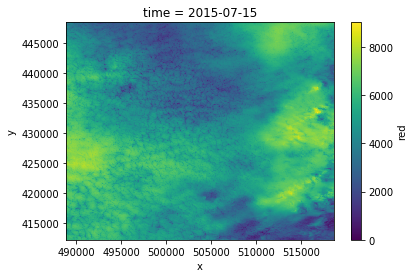

In [21]:
saldana.LC08.red.isel(time=1).plot()

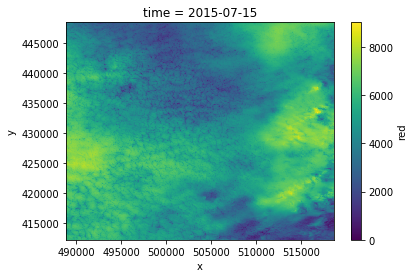

In [13]:
saldana.LC08.red.isel(time=1).plot()

In [12]:
saldana.LC08

<xarray.Dataset>
Dimensions:  (time: 15, x: 2976, y: 3630)
Coordinates:
  * y        (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-06-29 2015-07-15 2015-07-31 ...
    mask     (time, y, x) bool dask.array<shape=(15, 3630, 2976), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    green    (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    red      (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    nir      (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    swir1    (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    swir2    (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>

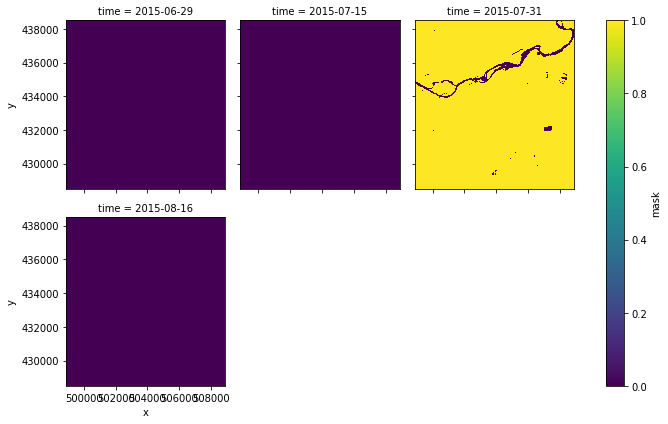

In [17]:
saldana.LC08.mask.isel(x=slice(1000,2000),y=slice(1000,2000),time=slice(0,4)).plot(col='time', col_wrap=3)

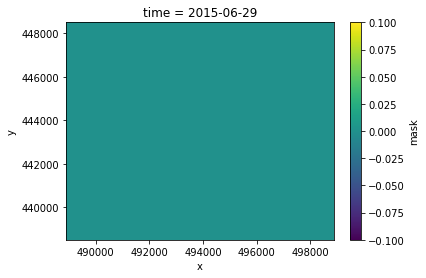

In [21]:
saldana.LC08.mask.isel(x=slice(0,1000),y=slice(0,1000),time=0).plot()

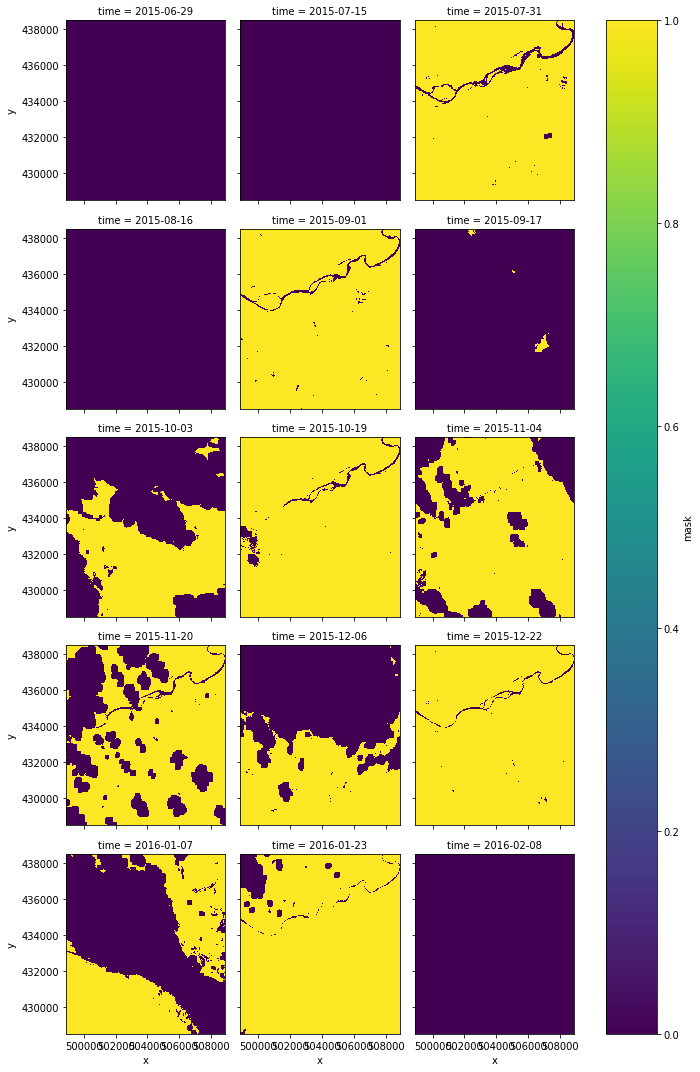

In [3]:
saldana.LC08.mask.isel(x=slice(1000,2000),y=slice(1000,2000)).plot(col='time', col_wrap=3)

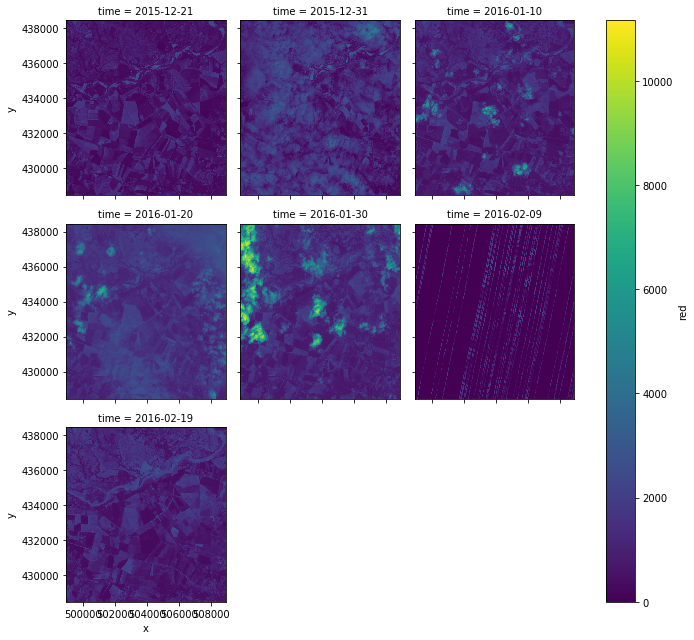

In [2]:
saldana.S2.red.isel(x=slice(1000,2000),y=slice(1000,2000)).plot(col='time', col_wrap=3)

In [23]:
saldana.S2

<xarray.Dataset>
Dimensions:  (time: 7, x: 2979, y: 3631)
Coordinates:
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...
    mask     (time, y, x) bool dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>
    red      (time, y, x) uint16 dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(7, 3631, 2979), chunksize=(1, 1000, 1000)>

In [24]:
saldana.LC08

<xarray.Dataset>
Dimensions:  (time: 15, x: 2976, y: 3630)
Coordinates:
  * y        (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-06-29 2015-07-15 2015-07-31 ...
    mask     (time, y, x) bool dask.array<shape=(15, 3630, 2976), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    green    (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    red      (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    nir      (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    swir1    (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>
    swir2    (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 15)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

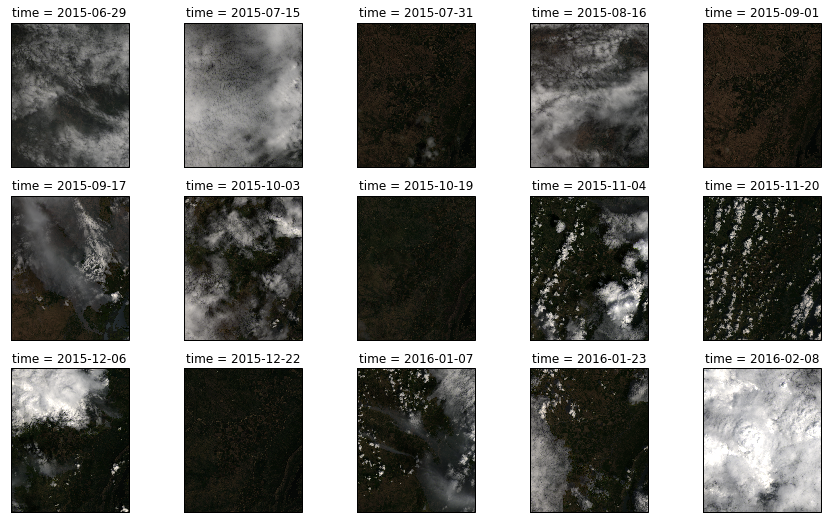

In [4]:
saldana.LC08.eotemp.plot_RGB()

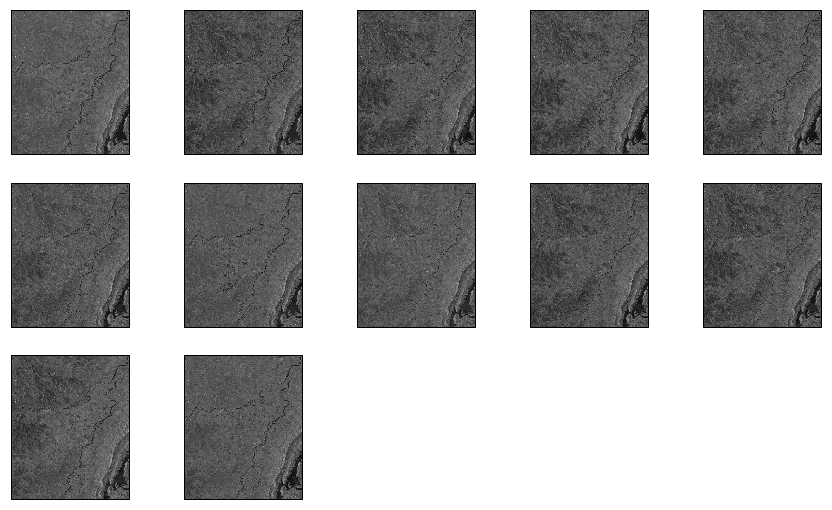

In [2]:
saldana.S1_ASCENDING.eotemp.plot_raster('VV', cmap='gray')

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/numpy/ma/core.py:716: UserW

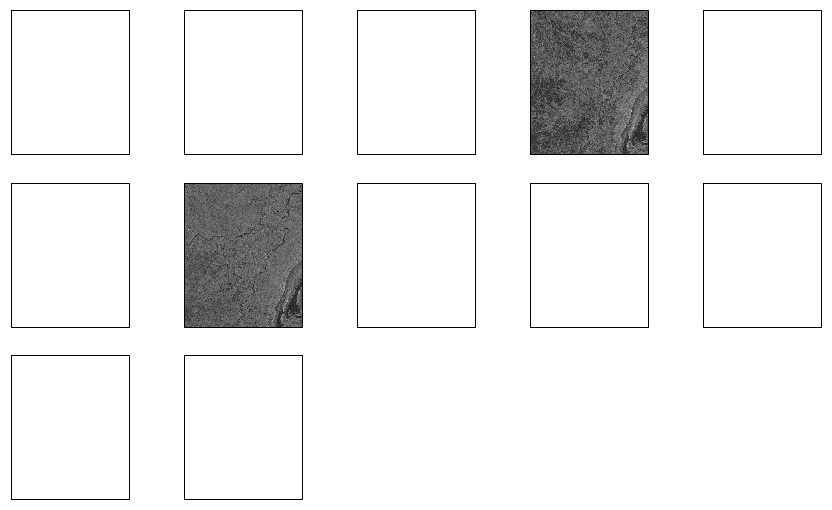

In [3]:
saldana.S1_ASCENDING.eotemp.plot_raster('VH', cmap='gray')

In [3]:
saldana.LC08

<xarray.Dataset>
Dimensions:  (time: 15, x: 2976, y: 3630)
Coordinates:
  * y        (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-06-29 2015-07-15 2015-07-31 ...
    mask     (y, x, time) uint16 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>
Data variables:
    blue     (y, x, time) float64 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>
    green    (y, x, time) float64 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>
    red      (y, x, time) float64 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>
    nir      (y, x, time) float64 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>
    swir1    (y, x, time) float64 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>
    swir2    (y, x, time) float64 dask.array<shape=(3630, 2976, 15), chunksize=(1000, 1000, 1)>

In [12]:
#saldana.harmonize_L8(rewrite=True)
import numpy as np
saldana.LC08['mask'] = (('y','x','time'),saldana.LC08.mask.data.astype(np.bool_))

Detected pixel offset (y, x): [3. 1.]
Pixel offset after correction in reference image (y, x): [0.36 0.18]
Warping blue band to y=-3.0,x=-1.0
Warping blue band failed with error <class 'TypeError'>, output_dtypes must be a list of objects coercible to numpy dtypes, got int16, <traceback object at 0x7f80e1df71c8>
Warping green band to y=-3.0,x=-1.0
Warping green band failed with error <class 'TypeError'>, output_dtypes must be a list of objects coercible to numpy dtypes, got int16, <traceback object at 0x7f80e8c02348>
Warping red band to y=-3.0,x=-1.0
Warping red band failed with error <class 'TypeError'>, output_dtypes must be a list of objects coercible to numpy dtypes, got int16, <traceback object at 0x7f80e8c02448>
Warping nir band to y=-3.0,x=-1.0
Warping nir band failed with error <class 'TypeError'>, output_dtypes must be a list of objects coercible to numpy dtypes, got int16, <traceback object at 0x7f80e8c02508>
Warping swir1 band to y=-3.0,x=-1.0
Warping swir1 band failed with 

In [7]:
type(saldana.LC08['red'].dtype)

numpy.dtype

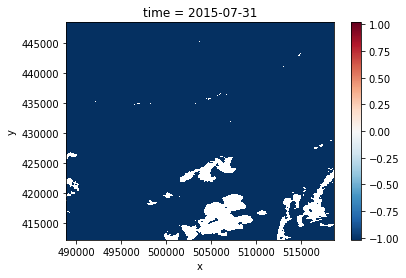

In [15]:
saldana.LC08.isel(time=2).blue.where(saldana.LC08.isel(time=2).mask).plot()

In [ ]:
saldana.harmonize_L8(rewrite=True)

In [ ]:
time_ranges = list(map(lambda x: getMonthRange(x), dataset.time.values))
        
        for drange in list(set(time_ranges)):
            
            month = drange[0].strftime('%Y%m')
            
            dataset.sel(time=slice(drange[0],drange[1])).to_netcdf(self.data_directory+'LC08_'+month+'.nc')

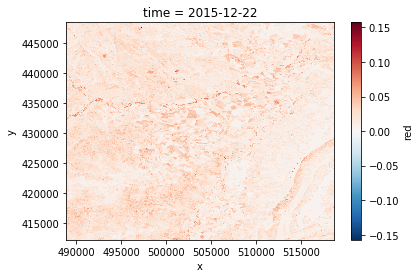

In [14]:
saldana.LC08.red.isel(time=3).plot()

In [15]:
from skimage.transform import warp
warp()

TypeError: warp() missing 2 required positional arguments: 'image' and 'inverse_map'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


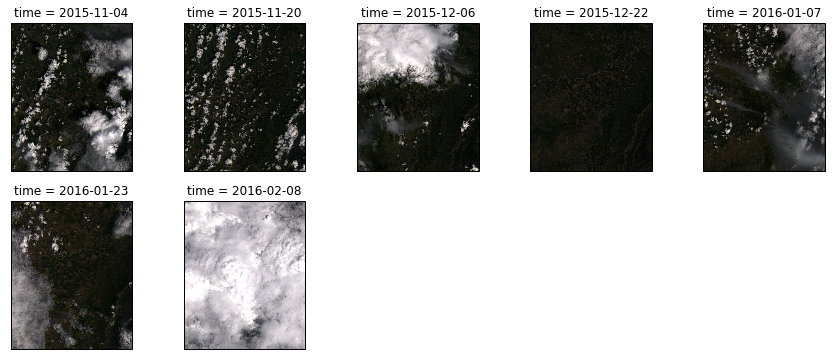

In [9]:
saldana.LC08.eotemp.plot_RGB()

In [8]:
import numpy as np
time=np.argmax(quality.values)

In [9]:
time

1

In [11]:
saldana.S2.isel(time=time)

<xarray.Dataset>
Dimensions:  (x: 2979, y: 3631)
Coordinates:
    time     datetime64[ns] 2015-12-21
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (y, x) int8 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
Data variables:
    blue     (y, x) uint16 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    swir1    (y, x) uint16 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    swir2    (y, x) uint16 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    green    (y, x) uint16 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    nir      (y, x) uint16 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    NDVI     (y, x) float32 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    LSWI     (y, x) float32 dask.array<shape=(3631, 2979), chunksize=(1000, 1000)>
    red      (y, x) uint16 dask.array<shape=(3631, 2979), chunksize=(

In [3]:
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
from scipy import interpolate

def interpolate_band(da, int_dates):
    # Apply ufunc-- inputs xr.DataArray and dates for interpolation
    # returns data array with interpolated values for int_dates
    result = xr.apply_ufunc(ufunc_cubic_spline, da,
                            input_core_dims=[['time']],
                            output_core_dims=[['ntime']],
                            kwargs={'axis': -1,
                                    'orig_times': da.time.values,
                                    'new_times': int_dates},
                            dask='parallelized',
                            output_dtypes=[np.float32],
                            output_sizes={'ntime':int_dates.shape[0]})
    result['ntime'] = ('ntime', int_dates)
    return result

def ufunc_cubic_spline(a, axis, orig_times, new_times):
    """
    
    """
    # Reshape array to 2d (pixels, dates)
    data = a.reshape(-1, a.shape[-1])
    # Fit cubic spline and interpolate dates
    results = np.apply_along_axis(int_cubic_spline, 1, data,
                                  orig_times=orig_times,
                                  new_times=new_times)
    # Reshape to original pixels (y,x) and number of interpolated dates
    return results.reshape((a.shape[0],a.shape[1],new_times.shape[0]))

def int_cubic_spline(y, orig_times, new_times):
    """
    Cubic spline fitting and interpolation
    
    Args:
        y (np 1d-array): response to fit spline
        orig_times (np 1d-array): predictor to fit spline
        new_times (np 1d-array): points to interpolate
    
    Returns:
        interpolated (np 1d-array): interpolated values
    """
    # Filter NaNs in response
    nans = np.isnan(y)
    # Try to fit cubic spline with filtered y values
    
    
    try:
        spl = interpolate.CubicSpline(orig_times.astype('d')[~nans],
                                      y[~nans])
        
        interpolated = spl(new_times.astype('d'))
    
    except ValueError:
        ## When spline cannot be fitted(not enought data), return NaN
        ## TODO raise warning
        interpolated = np.empty(new_times.shape[0])
        interpolated[:] = np.nan
        
    return interpolated

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """http://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html"""
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def calculate_time_periods(ds, time_delta=16, date_of_analysis=None):
    """
    Defines date of analysis and calculates times periods for remote sensing image dates
    interpolation.
    
    Args:
        ds (xr.DataArray or xr.Dataset): the dataset or data array with remote sensing images
        time_delta (int): period of time between dates for interpolation
        date_of_analysis(np.datetime64): default last date in dataset minus time_delta
    
    Returns:
        date_of_analysis (np.datetime64): the date to perform the analysis
        
    """
    # Extract time from Dataset/DataArray
    times = ds.sortby('time').time.values
    last_time = times[-1]
    first_time = times[0]
    
    # List to append dates for interpolation
    dfi = []
    
    # Define default date of analysis
    if date_of_analysis is None:
        date_of_analysis = last_time - np.timedelta64(time_delta, 'D')
    # Time post-analysis
    time = date_of_analysis + np.timedelta64(time_delta, 'D')
    # Append times to list
    while time > first_time:
        dfi.append(time)
        time -= np.timedelta64(time_delta, 'D')
    
    return date_of_analysis, np.array(dfi, dtype=np.datetime64)

def interpolate_dataset(dataset, location, bands=[]):
    
    dds = dataset.sortby('time').chunk({'time':-1,'x':100,'y':100}).persist()
    
    #output = []
    
    dof, times = calculate_time_periods(dds)
    
    for band in bands:    
        int_band = interpolate_band(dds[band], times)
        
        try: #try to apply pixel quality mask
            int_band = int_band.where(int_band.mask)
        except: #TODO spec tyope of error
            pass
        
        with ProgressBar():
            int_band.compute().to_netcdf(location+band+'.nc',engine='netcdf4')
    
    return xr.open_mfdataset(list(map(lambda x: location+x, os.listdir(loc))),
                            chunks={'ntime':1,'x':1000,'y':1000}, parallel=True)

In [6]:
import os
location = os.environ['WIN_SVR_DATA']+'Saldana_training_2015/interpolate/'

In [4]:
saldana.LC08

<xarray.Dataset>
Dimensions:  (time: 7, x: 2976, y: 3630)
Coordinates:
  * y        (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-11-04 2015-11-20 2015-12-06 ...
    mask     (time, y, x) int8 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (time, y, x) int16 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
    swir1    (time, y, x) int16 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
    swir2    (time, y, x) int16 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
    green    (time, y, x) int16 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
    nir      (time, y, x) int16 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
    NDVI     (time, y, x) float32 dask.array<shape=(7, 3630, 2976), chunksize=(1, 1000, 1000)>
    LSWI     (time, y, x) float

In [9]:
interps = xr.open_mfdataset(list(map(lambda x: location+x, os.listdir(location))),
                            chunks={'ntime':1,'x':1000,'y':1000}, parallel=True)

In [10]:
interps

<xarray.Dataset>
Dimensions:  (ntime: 5, x: 2979, y: 3631)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * ntime    (ntime) datetime64[ns] 2016-02-19 2016-02-03 2016-01-18 ...
Data variables:
    blue     (y, x, ntime) float64 dask.array<shape=(3631, 2979, 5), chunksize=(1000, 1000, 1)>
    LSWI     (y, x, ntime) float64 dask.array<shape=(3631, 2979, 5), chunksize=(1000, 1000, 1)>
    NDVI     (y, x, ntime) float64 dask.array<shape=(3631, 2979, 5), chunksize=(1000, 1000, 1)>

In [11]:
interpolate_dataset(saldana.S2, location, bands=['blue'])

In [229]:
dof, times = calculate_time_periods(rck)
print('Date of analysis is {}'.format(dof))
op = interpolate_band(rck, times)
results = op.compute()

Date of analysis is 2016-02-03T00:00:00.000000000


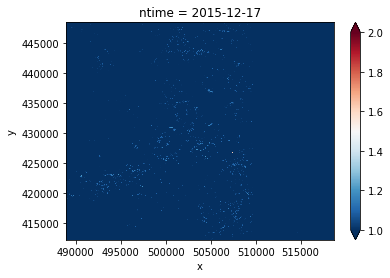

In [234]:
results.isel(ntime=-1).plot(vmin=1., vmax=2.,cmap='RdBu_r')

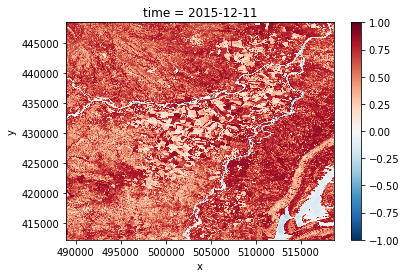

In [233]:
rck.isel(time=0).plot(vmin=-1., vmax=1.,cmap='RdBu_r')

### Older functions

Stack+unstack approach

In [ ]:
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
from scipy import interpolate

stack_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/'

files = list(map(lambda x: stack_dir+x, list(filter(re.compile('S2').search, os.listdir(stack_dir)))))

data_alt_chunk = xr.open_mfdataset(files, chunks={'x':1000,'y':1000}, parallel=True)

In [ ]:
def build_temp_dyn(dataset, function):
    
    darray = dataset.stack(pixels = ['y', 'x']).squeeze()
    darray = darray.reset_coords(drop=True)
    
    ## Calculate times to interpolate
    times = calculate_time_periods(dataset.time.values)
    
    sp_int = darray.groupby('pixels').apply(function, times=times)
    sp_int_unstacked = sp_int.unstack('pixels')
    
    sp_int_unstacked['time'] = ('dim_0', pd.DatetimeIndex(times))
    sp_int_unstacked = sp_int_unstacked.rename({'pixels_level_0':'y',
                                               'pixels_level_1':'x',
                                               'dim_0':'time'})
    
    return sp_int_unstacked
    
    
def xr_cubic_spline(y, times):
    
    nans = np.isnan(y.values)[:,0]
    
    spl = interpolate.CubicSpline(y.time.values.astype('d')[~nans],
                                  y.values[:,0][~nans],5,3))
    
    int_values = spl(times)
    
    return xr.DataArray(int_values)

def xr_cubic_spline_der(y, times):
    
    nans = np.isnan(y.values)[:,0]
    
    spl = interpolate.CubicSpline(y.time.values.astype('d')[~nans],
                                  savitzky_golay(y.values[:,0][~nans],5,3))
    
    der = spl.derivative()
    
    int_values = der(times)
    
    return xr.DataArray(int_values)

def calculate_time_periods(times):
    
    tdf = []
    
    # Todo make sure are ordered
    time = times[-1]
    min_time = times[0]
    
    while time > min_time:
        tdf.append(time)
        time -= np.timedelta64(16, 'D')
    
    #ts = (tdf - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 'D')
    
    return list(map(lambda x: x.astype('d'), tdf))

In [ ]:
subset_px = subset.isel(x=4,y=3)
nans = np.isnan(subset_px.values)
spl = interpolate.CubicSpline(subset_px.time.values.astype('d')[~nans], subset_px.values[~nans])
x2 = np.linspace(min(subset_px.time.values.astype('d')), max(subset_px.time.values.astype('d')), 200)
y2 = spl(x2)
plt.plot(calculate_time_periods(subset_px.time.values), spl(calculate_time_periods(subset_px.time.values)),
         'o', x2, y2, subset_px.time.values.astype('d')[~nans], subset_px.values[~nans])
plt.show()